In [21]:
import pandas as pd
import joblib
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
#adjustable variables
yearly_data_path = 'path/to/yearly/data/'
modelling_year = 2001
delay_group_threshold = 4

In [3]:
year_df = pd.read_csv(f'{yearly_data_path}{modelling_year}.csv')

In [5]:
def bin_time(crs_time):
    bin_dict = {0: '00-06', 1: '06-12', 2: '12-18', 3: '18-00'}
    if crs_time == 2400:
        return '18-00'
    return bin_dict[crs_time // 600]

def get_season(month):
    season_dict = {(1,2,3): 'spring', (4,5,6): 'summer', (7,8,9): 'autumn', (10,11,12): 'winter'}
    for key, val in season_dict.items():
        if month in key:
            return val

In [4]:
#preprocessing
dep_use_cols = ['MONTH', 'DAY_OF_WEEK', 'CRS_DEP_TIME', 'DISTANCE', 'PRCP_ORIGIN', 'SNOW_ORIGIN', 'SNWD_ORIGIN', 'TMAX_ORIGIN', 'TMIN_ORIGIN', 'DEP_DELAY_GROUP']
dep_df = year_df[dep_use_cols]
dep_df = dep_df[pd.notnull(dep_df['DEP_DELAY_GROUP'])]
dep_df['HAS_DEP_DELAY'] = dep_df['DEP_DELAY_GROUP'].apply(lambda x: 1 if x >= 4 else 0)
dep_df['CRS_DEP_BIN'] = dep_df['CRS_DEP_TIME'].apply(bin_time)        
dep_df['SEASON'] = dep_df['MONTH'].apply(get_season)
dep_df = dep_df.astype({'DAY_OF_WEEK': 'string'})

In [10]:
#train-test split
dep_regression_cols = ['SEASON', 'DAY_OF_WEEK', 'CRS_DEP_BIN', 'DISTANCE', 'PRCP_ORIGIN', 'SNOW_ORIGIN', 'SNWD_ORIGIN', 'TMAX_ORIGIN', 'TMIN_ORIGIN']
dep_X = pd.get_dummies(dep_df[dep_regression_cols])
dep_X = dep_X.dropna()
dep_y = dep_df['HAS_DEP_DELAY']
dep_X_train, dep_X_test, dep_y_train, dep_y_test = train_test_split(dep_X, dep_y, test_size = 0.2)

In [ ]:
#train model
dep_rf = RandomForestClassifier()
dep_rf.fit(dep_X_train, dep_y_train)

In [ ]:
#joblib.dump(dep_rf, 'dep_rf.joblib')
#dep_rf = joblib.load('dep_rf.joblib')

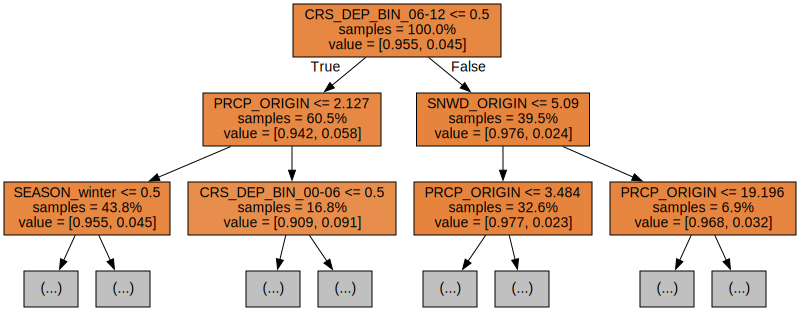

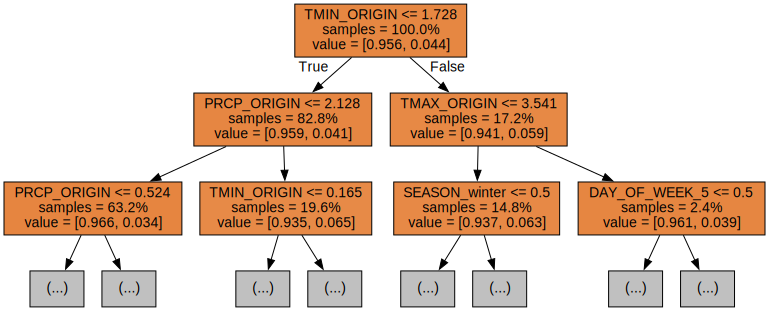

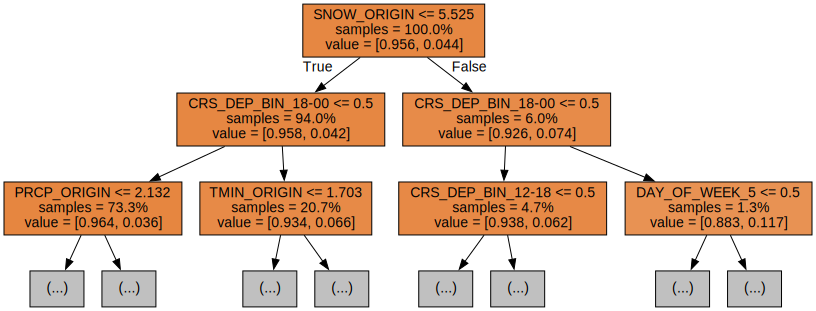

In [13]:
# Export the first three decision trees from the forest
for i in range(3):
    tree = dep_rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=dep_X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

In [ ]:
dep_y_pred = dep_rf.predict(dep_X_test)

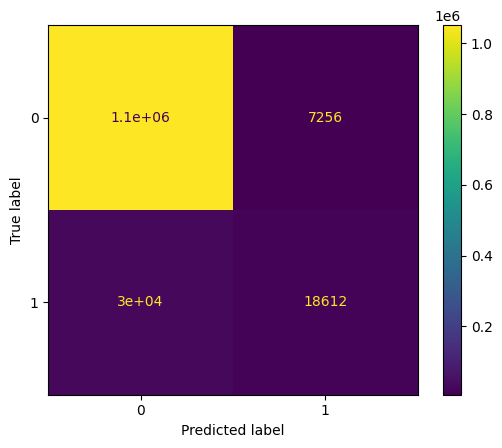

In [14]:
dep_cm = confusion_matrix(dep_y_test, dep_y_pred)
ConfusionMatrixDisplay(confusion_matrix=dep_cm).plot()

In [15]:
dep_accuracy = accuracy_score(dep_y_test, dep_y_pred)
dep_precision = precision_score(dep_y_test, dep_y_pred)
dep_recall = recall_score(dep_y_test, dep_y_pred)

print("Accuracy:", dep_accuracy)
print("Precision:", dep_precision)
print("Recall:", dep_recall)

Accuracy: 0.9659799809996497
Precision: 0.7194989948971703
Recall: 0.37961980908868403


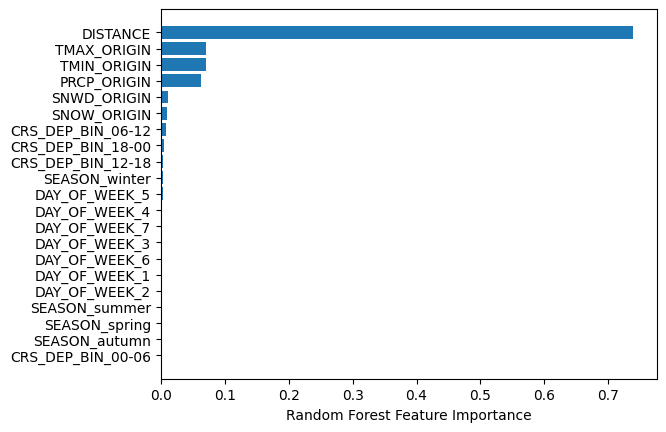

In [29]:
dep_feature_importances = pd.Series(dep_rf.feature_importances_, index=dep_X_train.columns).sort_values(ascending = False)
plt.barh(dep_feature_importances.index, dep_feature_importances.values)
plt.xlabel("Random Forest Feature Importance")
plt.gca().invert_yaxis()